# Goal: Explore Conditional GAN

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## MNIST Data

For this demo, we will be using the MNIST data set. We can apply GANs to other datasets but the training process takes much longer. Our goal will be to supply random noise and a class label (e.g. a digit between 0 and 9) to the generator and produce an image of that particular digit.

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])])

data = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
batch_size = 64
data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, drop_last=True)

We drop the last batch in our training set. We do this so that each batch passed into our networks is always of size 64 (since the number of training samples isn't divisible by 64). Also take a careful look at our normalization factors ($\mu, \sigma=0.5$). By using these normalization factors, we constrain each pixel value in our image to within $[-1, 1]$:

In [ ]:
images, _ = next(iter(data_loader))
print("min pixel value:", images.min())
print("max pixel value:", images.max())
print("avg pixel value:", images.mean())

min pixel value: tensor(-1.)
max pixel value: tensor(1.)
avg pixel value: tensor(-0.7313)


This normalization strategy will come in handy for our generator: the last-layer activation function will be `tanh` which is also constrained to be within $[-1,1]$.

## Building $G$ and $D$

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_size=100, num_classes=10, image_size=28*28):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(noise_size+num_classes, 128), # [noise input, one-hot label] concatenated 
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size), # flattened image
            nn.Tanh() # min value: -1, max value: 1
        )
        
    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [noise input, one-hot label] concatenated vector
        y_ = self.network(v)
        y_ = y_.view(x.size(0), 1, 28, 28) # flattened image
        return y_

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, image_size=28*28, num_classes=10, num_output=1):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(image_size+num_classes, 512),   # [flattened image, one-hot label] concatenated vector
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_output),
            nn.Sigmoid(), #min value: 0, max value: 1 -> great for probabilities!
        )
    
    def forward(self, x, c):        
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [flattened image, one-hot label] concatenated vector
        y_ = self.network(v)
        return y_

## Training Setup

Now, we're ready to instantiate our models, hyperparameters, and optimizers. Since the task is so easy for MNIST, we will train for only 10 epochs. We will update the generator and discriminator in every step but often one can be trained more frequently than the other. We need to instantiate two optimizers: one for each newtork. 

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", DEVICE)

D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

max_epoch = 10
step = 0
n_noise = 100 # size of noise vector

criterion = nn.BCELoss() # binary-cross entropy loss
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# We will denote real images as having a label 1 and fake images as having a label of 0
# This is why we needed to drop the last batch of the data loader
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator label: real image
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label: fake image

device: cuda


## Training
Now, let's train both networks. Remember that we will have two loss terms for the discriminator and one loss term for the generator.

In [ ]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        x = images.to(DEVICE)
        y = labels.to(DEVICE)
        y = F.one_hot(y, num_classes=10)
        

        # Discriminator - Real Images
        x_outputs = D(x, y)                              # pass images and class labels to discriminator
        D_x_loss = criterion(x_outputs, D_labels)        # Discriminator loss for real images
        
        # Discriminator - Fake Images
        z = torch.randn(batch_size, n_noise).to(DEVICE)  # sample from standard dist.
        z_ = G(z,y)                                      # pass noise and class label to generator
        z_outputs = D(z_, y)                             # pass fake images and label to discriminator
        D_z_loss = criterion(z_outputs, D_fakes)         # Discriminator loss for fake images
        
        D_loss = D_x_loss + D_z_loss                     # Total Discriminator loss
        
        # Optimize the Discriminator
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        # Generator - Fake Images
        z = torch.randn(batch_size, n_noise).to(DEVICE)  # sample from standard dist.
        z_ = G(z,y)                                      # pass noise and class label to generator
        z_outputs = D(z_, y)                             # pass fake images and label to discriminator
        G_loss = -1 * criterion(z_outputs, D_fakes)      # Generator loss is negative disciminator fake-loss

        # Optimize the Generator
        G.zero_grad()
        G_loss.backward()
        G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        step += 1

Epoch: 0/10, Step: 0, D Loss: 1.383345365524292, G Loss: -0.6775472164154053
Epoch: 0/10, Step: 500, D Loss: 1.3113811016082764, G Loss: -0.5134172439575195
Epoch: 1/10, Step: 1000, D Loss: 1.415831446647644, G Loss: -0.26758670806884766
Epoch: 1/10, Step: 1500, D Loss: 0.8949247002601624, G Loss: -0.5527048110961914
Epoch: 2/10, Step: 2000, D Loss: 1.3046650886535645, G Loss: -0.5584967732429504
Epoch: 2/10, Step: 2500, D Loss: 1.239891767501831, G Loss: -0.45827552676200867
Epoch: 3/10, Step: 3000, D Loss: 1.4110296964645386, G Loss: -0.5067005157470703
Epoch: 3/10, Step: 3500, D Loss: 1.1709760427474976, G Loss: -0.5282682180404663
Epoch: 4/10, Step: 4000, D Loss: 1.213775396347046, G Loss: -0.6103003621101379
Epoch: 4/10, Step: 4500, D Loss: 1.258767008781433, G Loss: -0.5418068766593933
Epoch: 5/10, Step: 5000, D Loss: 1.3338922262191772, G Loss: -0.5702112913131714
Epoch: 5/10, Step: 5500, D Loss: 1.3585987091064453, G Loss: -0.7409588098526001
Epoch: 6/10, Step: 6000, D Loss: 1.

## Generate Samples (Conditioned on the class label!)
Let's generate a few samples now! Don't forget to set the generator to `eval` mode. We have layers in our generator that work differently during training and inference time (which one?). Let's set the class label to 8 and generate a few samples.

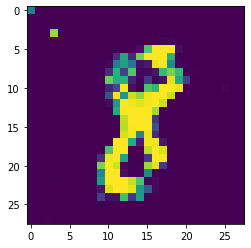

In [ ]:
G.eval()

z = torch.randn(1, n_noise).to(DEVICE)          # random noise vector 1x100

label = 8
label = torch.tensor([label])
c = F.one_hot(label, num_classes=10).to(DEVICE) # one-hot encoding 1x10

y_hat = G(z, c).view(1, 28, 28)
plt.imshow(y_hat.squeeze().detach().cpu())

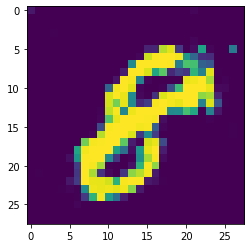

In [ ]:
G.eval()

z = torch.randn(1, n_noise).to(DEVICE)          # random noise vector 1x100

label = 8
label = torch.tensor([label])
c = F.one_hot(label, num_classes=10).to(DEVICE) # one-hot encoding 1x10

y_hat = G(z, c).view(1, 28, 28)
plt.imshow(y_hat.squeeze().detach().cpu())

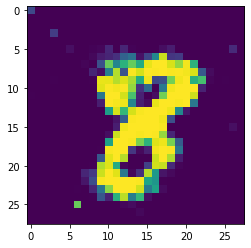

In [ ]:
G.eval()

z = torch.randn(1, n_noise).to(DEVICE)          # random noise vector 1x100

label = 8
label = torch.tensor([label])
c = F.one_hot(label, num_classes=10).to(DEVICE) # one-hot encoding 1x10

y_hat = G(z, c).view(1, 28, 28)
plt.imshow(y_hat.squeeze().detach().cpu())

And that's it! In this demo, we explored conditional GANs and looked a bit closely at the loss function used in GANs. Since GANs, there have been newer generative models such as diffusion models. 